In [1]:
import polars as pl 
import re
import yaml 
from utils.process import get_specie


cov = 0.5

# Load yaml file
with open('/home/sherman/Bureau/Gits/Elongates/env.yaml', 'r') as f:
    yaml_data = yaml.safe_load(f)
    species_dict = {k: v for d in yaml_data['Regex'].values() for k, v in d.items()}
    species_order = yaml_data['Species_order']['Scer']
    re_dict = yaml_data['Regex']['Scer']


def is_monophyletic(binary_vector):
    
    two_index = binary_vector.index(2)

    ones_after_two = binary_vector[two_index:]
    start_index = ones_after_two.index(1) + two_index
    end_index = len(ones_after_two) - 1 - ones_after_two[::-1].index(1) + two_index

    if 1 in binary_vector[:two_index] or 0 in binary_vector[start_index:end_index+1]:
        return False
    else:
        return True

    
def parse_blast_dataframe(row : tuple) -> tuple:

    query_pattern = r'(.*?)-(cluster_n\d+)'
    subject_pattern = r'(.*?)-(cluster_n\d+)-.*-(f\d+)-.*'

    query_id = row[0]
    subject_id = row[1]
    evalue = row[2]
    qstart = row[3]
    qend = row[4]
    sstart = row[5]
    send = row[6]
    qseq = row[7]
    sseq = row[8]
    length = row[9]
    blast_gapopen = row[10]
    blast_gaps = row[11]



    query_matches = re.match(query_pattern, query_id)
    query_seq_id = query_matches.group(1) if query_matches else None
    query_cluster = query_matches.group(2) if query_matches else None

    subject_matches = re.match(subject_pattern, subject_id)
    subject_seq_id = subject_matches.group(1) if subject_matches else None
    subject_cluster = subject_matches.group(2) if subject_matches else None
    subject_relative_frame = subject_matches.group(3) if subject_matches else None

    is_same_cluster = int(query_cluster == subject_cluster)
    q_specie = get_specie(re_dict, query_seq_id)
    s_specie = get_specie(re_dict, subject_seq_id)

    tuple_ = tuple([query_seq_id, subject_seq_id, evalue, qstart, qend, sstart, send, 
                    qseq, sseq, length, blast_gapopen, blast_gaps, query_cluster, subject_cluster, subject_relative_frame, 
                    is_same_cluster, q_specie, s_specie])
    return tuple_


def analyze_monophyly(dataframe, species_order):

    tmp_id = list()
    tmp_vector = list()
    tmp_bool = list()

    for query, matches in dataframe.groupby("qseqid"):
        if len(matches["q_specie"].unique().to_list()) > 1:
            raise KeyError("Multiple query species found")
        else:
            q_specie = matches["q_specie"].unique().to_list()[0]  # Supposedly only one query specie

        species = matches["s_specie"].unique().to_list()
        species = [1 if item in species else 0 for item in species_order]
        try:
            index = species_order.index(q_specie)
            species[index] = 2
        except ValueError:
            pass

        tmp_id.append(query)
        tmp_vector.append(str(species))
        try:
            tmp_bool.append(False if 0 in species[2 : len(species) - species[::-1].index(1)] else True)
        except ValueError:
            tmp_bool.append(True) # If only 2 in the vector, q_specie == s_specie 


    result_df = pl.DataFrame({
        'query': tmp_id,
        'vector': tmp_vector,
        'is_monophyletic': tmp_bool
    })

    print(dataframe.columns)

    dataframe = dataframe.join(result_df, left_on="qseqid", right_on="query")

    return dataframe



columns =  ["qseqid", "sseqid", "evalue", "qstart", "qend", "sstart", "send", "qseq", "sseq", "length", "blast_gapopen", "blast_gaps"]
df_blast_cter  = pl.read_csv(f"output/{cov}/cter_three_{cov}.tsv", separator="\t", has_header = False, infer_schema_length = 100000)
df_blast_cter.columns = columns
df_blast_cter = df_blast_cter.with_columns(
    pl.lit("NA").alias('query_cluster'),
    pl.lit("NA").alias('subject_cluster'),
    pl.lit("NA").alias('relative_frame'),
    pl.lit("NA").alias('same_cluster'),
    pl.lit("NA").alias('q_specie'),
    pl.lit("NA").alias('s_specie')
)


columns = df_blast_cter.columns
df_blast_cter = df_blast_cter.apply(parse_blast_dataframe)
df_blast_cter.columns = columns

cter_elongates_data = pl.read_csv(f"output/{cov}/0.5_elongates.csv", infer_schema_length = 100000).select("cluster_size","seq_id",
                                                           "Cter_gaps","Cter_gap_openings","Cter_nb_aa",
                                                           "Cter_elongate_length","Cter_ratio",
                                                           "is_max_Cter","is_min_Cter",
                                                           "Cter_event_ID","Cter_events")



df_cter = df_blast_cter.join(cter_elongates_data, left_on="qseqid", right_on="seq_id")
df_cter = df_cter.filter((pl.col("Cter_gap_openings") == 0))
df_cter = analyze_monophyly(df_cter, species_order)


###############################

columns =  ["qseqid", "sseqid", "evalue", "qstart", "qend", "sstart", "send", "qseq", "sseq", "length", "blast_gapopen", "blast_gaps"]
df_blast_nter  = pl.read_csv(f"output/{cov}/nter_five_{cov}.tsv", separator="\t", has_header = False, infer_schema_length = 100000)
df_blast_nter.columns = columns

df_blast_nter = df_blast_nter.with_columns(
    pl.lit("NA").alias('query_cluster'),
    pl.lit("NA").alias('subject_cluster'),
    pl.lit("NA").alias('relative_frame'),
    pl.lit("NA").alias('same_cluster'),
    pl.lit("NA").alias('q_specie'),
    pl.lit("NA").alias('s_specie')
)


columns = df_blast_nter.columns
df_blast_nter = df_blast_nter.apply(parse_blast_dataframe)
df_blast_nter.columns = columns



nter_elongates_data = pl.read_csv(f"output/{cov}/0.5_elongates.csv", infer_schema_length = 100000).select("cluster_size","seq_id",
                                                           "Nter_gaps","Nter_gap_openings","Nter_nb_aa",
                                                           "Nter_elongate_length","Nter_ratio",
                                                           "is_max_Nter","is_min_Nter",
                                                           "Nter_event_ID","Nter_events",
                                                           "Meth_after_Nter", "cluster_name")



df_nter = df_blast_nter.join(nter_elongates_data, left_on="qseqid", right_on="seq_id")
df_nter = df_nter.filter((pl.col("Nter_gap_openings") == 0))
df_nter = analyze_monophyly(df_nter, species_order)

print(df_nter.columns)

['qseqid', 'sseqid', 'evalue', 'qstart', 'qend', 'sstart', 'send', 'qseq', 'sseq', 'length', 'blast_gapopen', 'blast_gaps', 'query_cluster', 'subject_cluster', 'relative_frame', 'same_cluster', 'q_specie', 's_specie', 'cluster_size', 'Cter_gaps', 'Cter_gap_openings', 'Cter_nb_aa', 'Cter_elongate_length', 'Cter_ratio', 'is_max_Cter', 'is_min_Cter', 'Cter_event_ID', 'Cter_events']
['qseqid', 'sseqid', 'evalue', 'qstart', 'qend', 'sstart', 'send', 'qseq', 'sseq', 'length', 'blast_gapopen', 'blast_gaps', 'query_cluster', 'subject_cluster', 'relative_frame', 'same_cluster', 'q_specie', 's_specie', 'cluster_size', 'Nter_gaps', 'Nter_gap_openings', 'Nter_nb_aa', 'Nter_elongate_length', 'Nter_ratio', 'is_max_Nter', 'is_min_Nter', 'Nter_event_ID', 'Nter_events', 'Meth_after_Nter', 'cluster_name']
['qseqid', 'sseqid', 'evalue', 'qstart', 'qend', 'sstart', 'send', 'qseq', 'sseq', 'length', 'blast_gapopen', 'blast_gaps', 'query_cluster', 'subject_cluster', 'relative_frame', 'same_cluster', 'q_spec

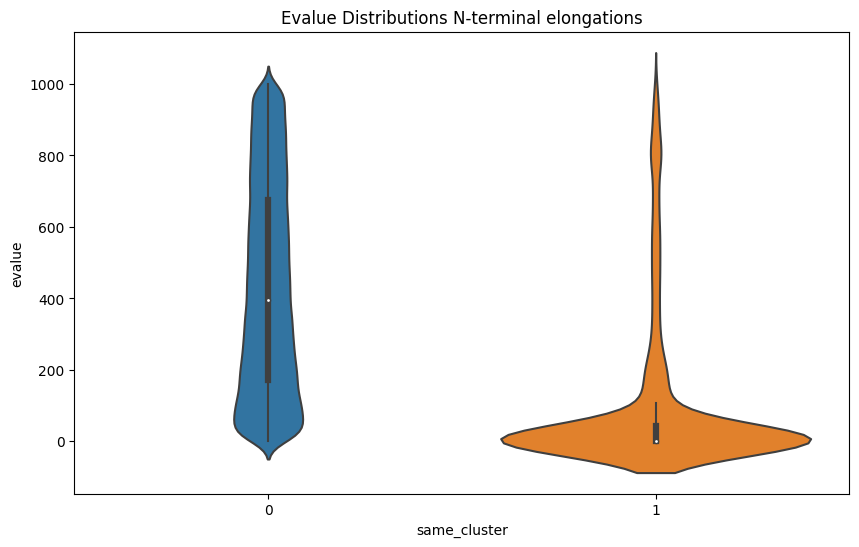

/home/sherman/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


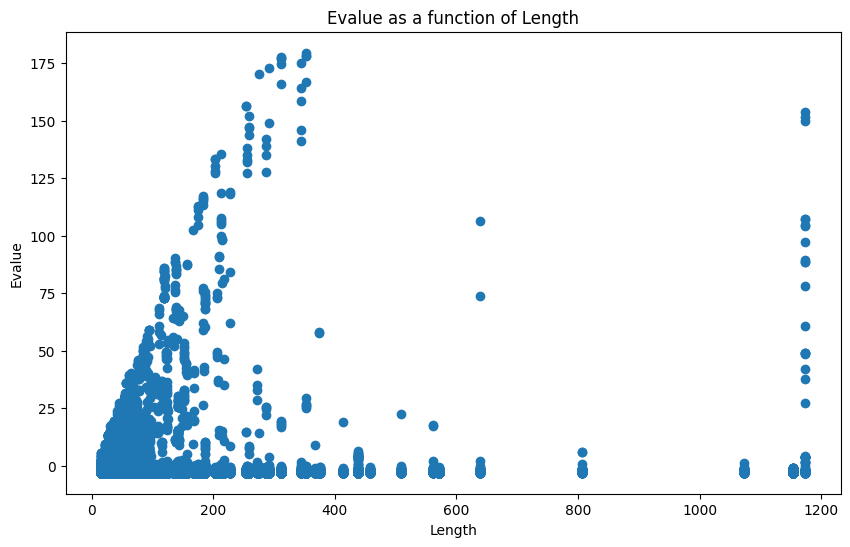

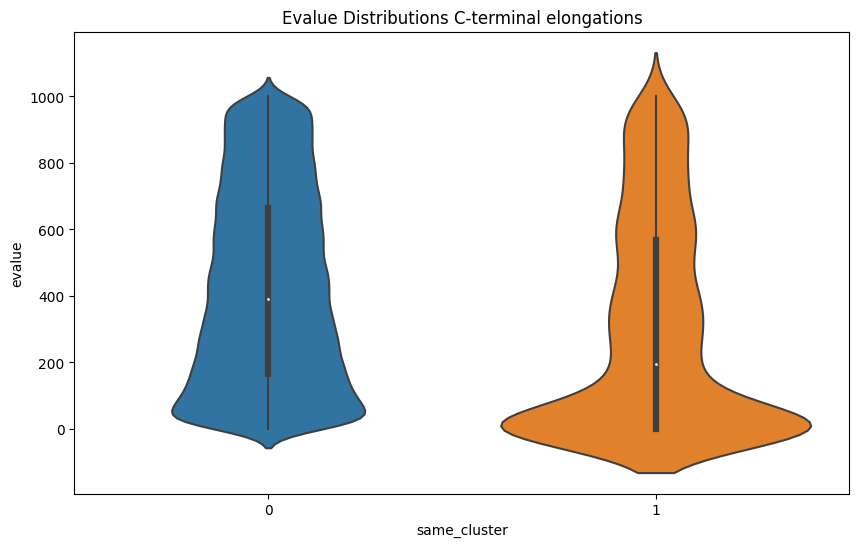

/home/sherman/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


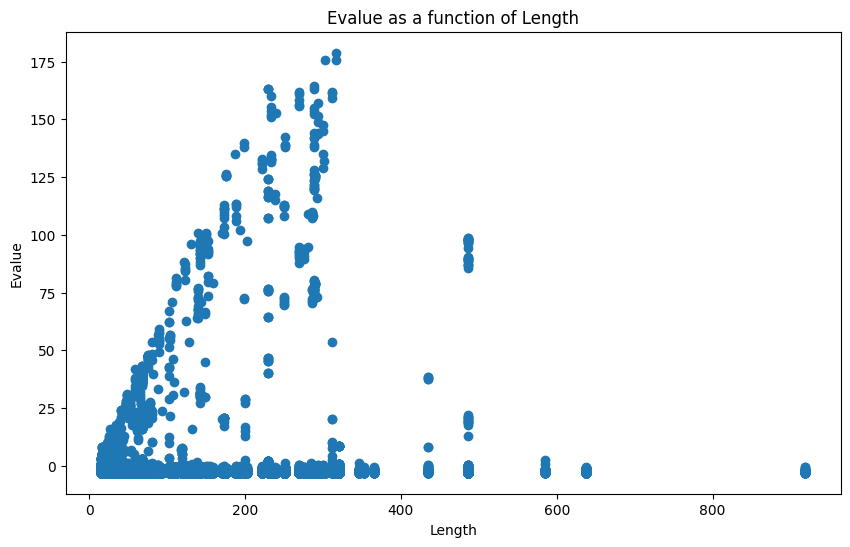

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

CSTE = 0.0000001

# Convert your Polars DataFrame to Pandas DataFrame
df_pd = df_nter.to_pandas()

plt.figure(figsize=(10, 6))
sns.violinplot(x='same_cluster', y='evalue', data=df_pd)
plt.title('Evalue Distributions N-terminal elongations')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_pd['Nter_elongate_length'], -np.log10(df_pd['evalue']) + CSTE)
plt.xlabel('Length')
plt.ylabel('Evalue')
plt.title('Evalue as a function of Length')
plt.show()

# Convert your Polars DataFrame to Pandas DataFrame
df_pd = df_cter.to_pandas()

plt.figure(figsize=(10, 6))
sns.violinplot(x='same_cluster', y='evalue', data=df_pd)
plt.title('Evalue Distributions C-terminal elongations')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_pd['Cter_elongate_length'], -np.log10(df_pd['evalue']) + CSTE)
plt.xlabel('Length')
plt.ylabel('Evalue')
plt.title('Evalue as a function of Length')
plt.show()



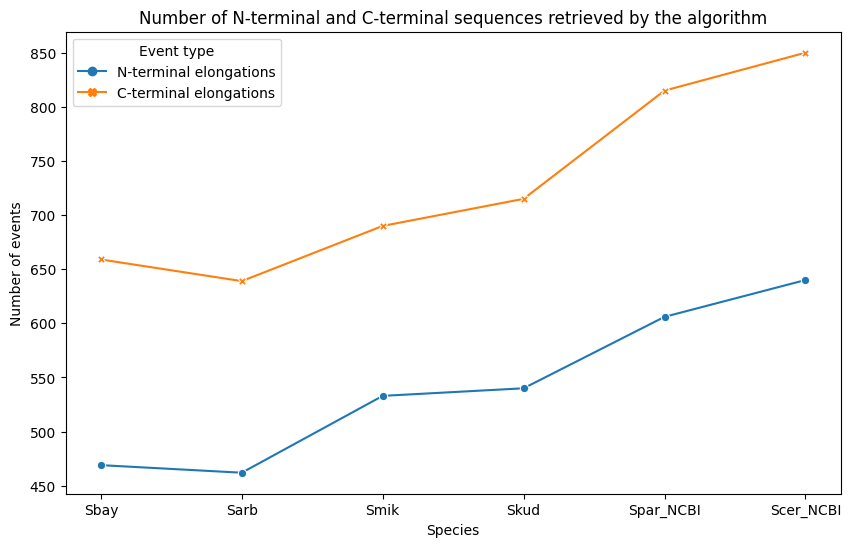

In [16]:
import polars as pl
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cov = 0.5

elongates = pl.read_csv(f"output/{cov}/{cov}_elongates.csv", infer_schema_length =100000)


species_order = ["Sbay","Sarb","Smik","Skud","Spar_NCBI","Scer_NCBI"]
data_lists_nter = dict()
data_lists_cter = dict()
for species in species_order:
        
        data_lists_nter[species] = elongates.filter((pl.col("species") == species) & (pl.col("Nter_nb_aa") > 0)).shape[0]
        data_lists_cter[species] = elongates.filter((pl.col("species") == species) & (pl.col("Cter_nb_aa") > 0)).shape[0]


nter_events = [data_lists_nter[species] for species in species_order]
cter_events = [data_lists_cter[species] for species in species_order]


# Prepare a dataframe for Seaborn
data = pd.DataFrame({
    'Species': species_order * 2,
    'Number of events': nter_events + cter_events,
    'Event type': ['N-terminal elongations'] * len(nter_events) + ['C-terminal elongations'] * len(cter_events)
})

# Create a Seaborn lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Species', y='Number of events', hue='Event type', style='Event type', markers=True, dashes=False, data=data)

# Add title
plt.title('Number of N-terminal and C-terminal sequences retrieved by the algorithm')

# Show the plot
plt.show()

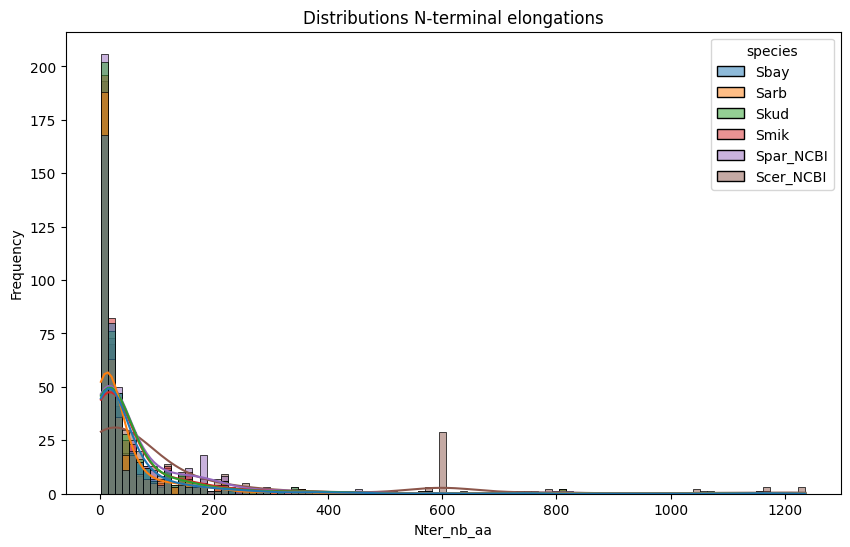

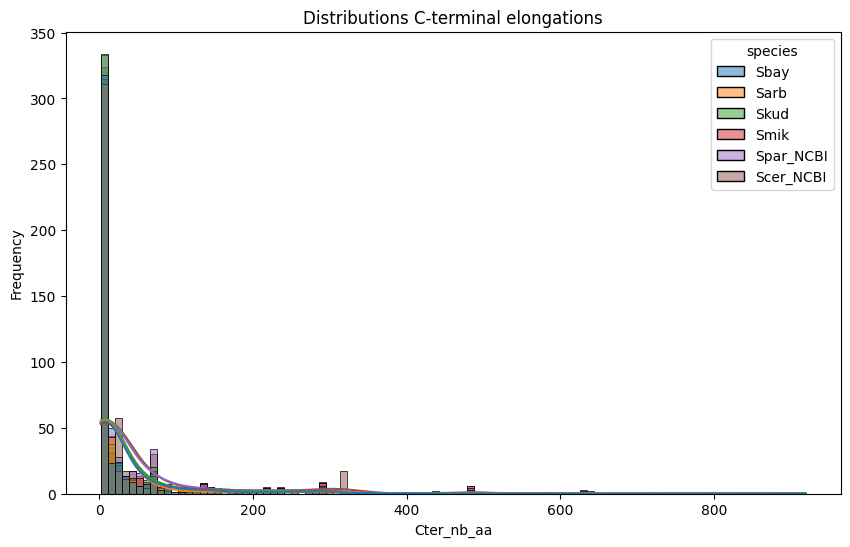

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_nter = elongates.filter((pl.col("Nter_nb_aa") > 1) ).to_pandas()
data_cter = elongates.filter((pl.col("Cter_nb_aa") > 1) ).to_pandas()

# Define the number of bins and the range of x-axis

x_range = (0, 500)  # Set your desired x-axis range
plt.figure(figsize=(10, 6))
sns.histplot(x=data_nter['Nter_nb_aa'], bins=100, kde = True, hue = data_nter["species"])
# Set the range of x-axis
#plt.xlim(x_range)
plt.title('Distributions N-terminal elongations')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(x=data_cter['Cter_nb_aa'], bins=100, kde = True, hue = data_cter["species"])
# Set the range of x-axis
#plt.xlim(x_range)
plt.title('Distributions C-terminal elongations')
plt.ylabel('Frequency')
plt.show()


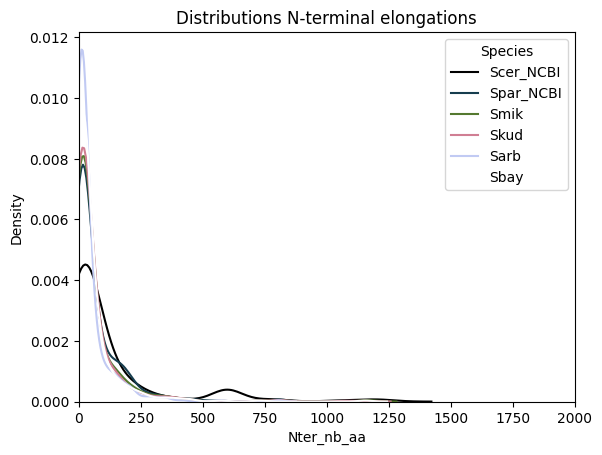

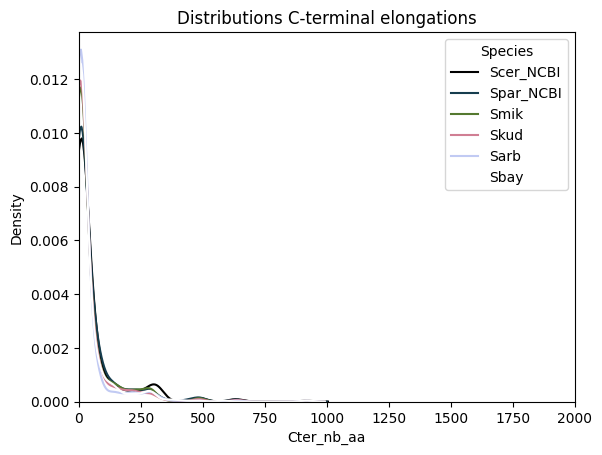

In [20]:
import matplotlib.colors as mcolors


cmap = plt.get_cmap('cubehelix', len(species_order))  
colors = [cmap(i) for i in range(cmap.N)]
color_map = dict(zip(["Scer_NCBI","Spar_NCBI","Smik", "Skud","Sarb","Sbay"], colors))

# Generate KDE plot for each species
for species in ["Scer_NCBI","Spar_NCBI","Smik", "Skud","Sarb","Sbay"]:
    species_data = data_nter[data_nter["species"] == species]
    sns.kdeplot(x=species_data['Nter_nb_aa'], label=species, color=color_map[species])

# Set the range of x-axis
plt.xlim(0,2000)
plt.title('Distributions N-terminal elongations')
plt.ylabel('Density')
plt.legend(title='Species')
plt.show()

# Generate KDE plot for each species
for species in ["Scer_NCBI","Spar_NCBI","Smik", "Skud","Sarb","Sbay"]:
    species_data = data_cter[data_cter["species"] == species]
    sns.kdeplot(x=species_data['Cter_nb_aa'], label=species, color=color_map[species])

# Set the range of x-axis
plt.xlim(0,2000)
plt.title('Distributions C-terminal elongations')
plt.ylabel('Density')
plt.legend(title='Species')
plt.show()

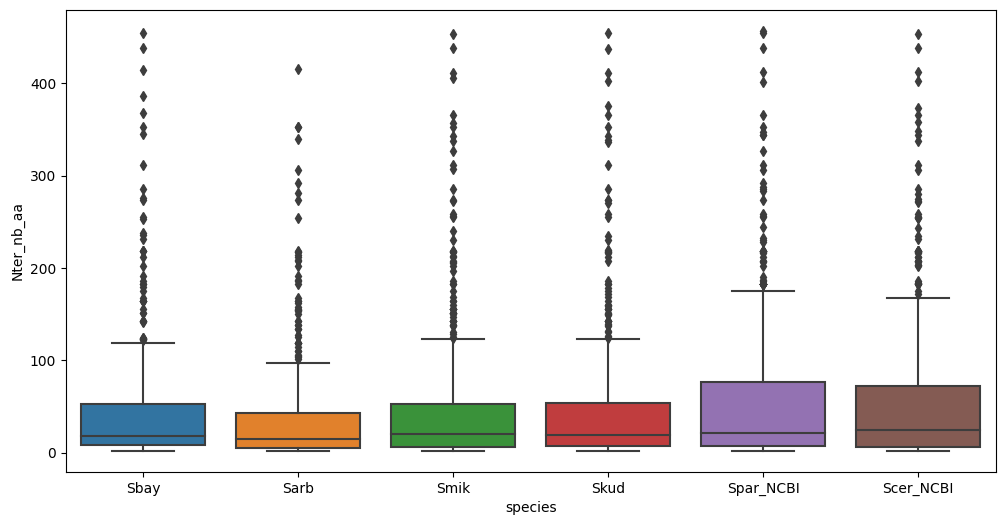

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='species', y='Nter_nb_aa', data=data_nter, order=species_order)
plt.title('')
plt.show()

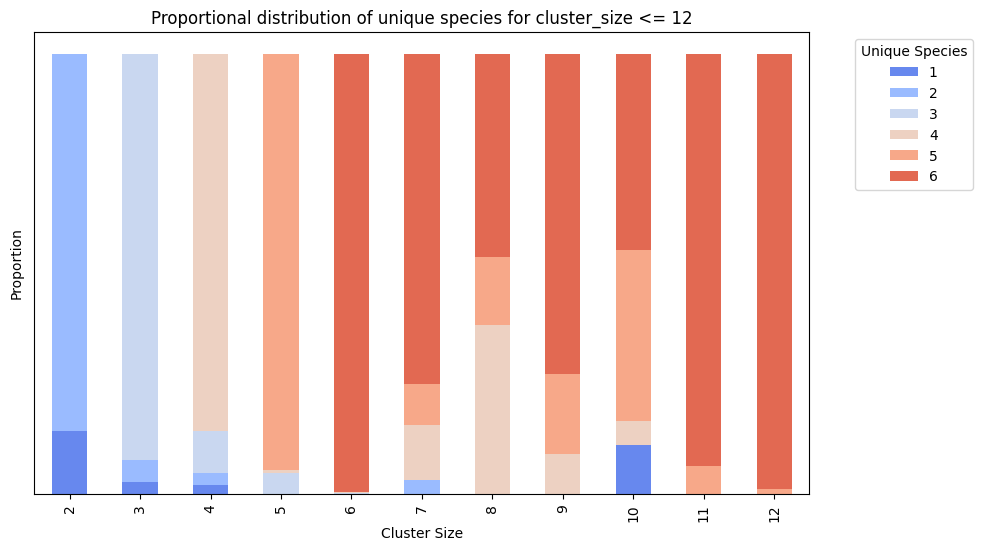

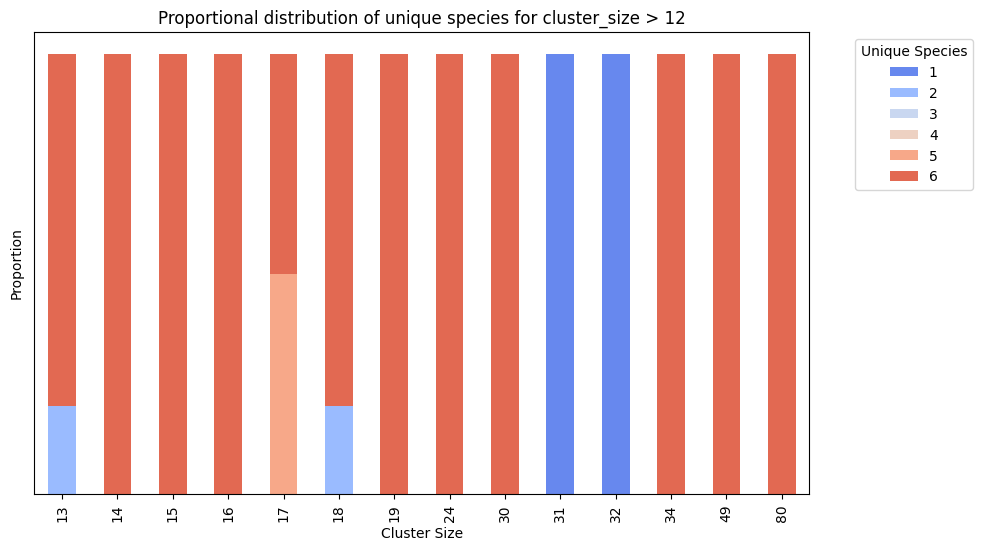

In [14]:
import polars as pl 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


cov = 0.5

df = pl.read_csv(f"output/{cov}/{cov}_elongates.csv", infer_schema_length =100000)



pdf = df.to_pandas()

unique_species_values = sorted(df['unique_species'].unique())

colors = sns.color_palette("coolwarm", n_colors=len(unique_species_values))
color_map = dict(zip(unique_species_values, colors))


grouped = pdf.groupby(['cluster_size', 'unique_species']).size().reset_index(name='count')

pivot_df = grouped.pivot(index='cluster_size', columns='unique_species', values='count').fillna(0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)  # Normalize to make sum of each row equal to 1


threshold = 12
part1_df = pivot_df[pivot_df.index <= threshold]
part2_df = pivot_df[pivot_df.index > threshold]

plt.figure(figsize=(10,6))
part1_df.plot(kind='bar', stacked=True, color=[color_map[col] for col in pivot_df.columns], ax=plt.gca())
plt.title(f'Proportional distribution of unique species for cluster_size <= {threshold}')
plt.ylabel('Proportion')
plt.xlabel('Cluster Size')
plt.yticks([])
plt.legend(title='Unique Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(-0.5, len(part1_df)-0.5)  
plt.show()

plt.figure(figsize=(10,6))
part2_df.plot(kind='bar', stacked=True, color=[color_map[col] for col in pivot_df.columns], ax=plt.gca())
plt.title(f'Proportional distribution of unique species for cluster_size > {threshold}')
plt.ylabel('Proportion')
plt.xlabel('Cluster Size')
plt.legend(title='Unique Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks([])
plt.xlim(-0.5, len(part2_df)-0.5)
plt.show()

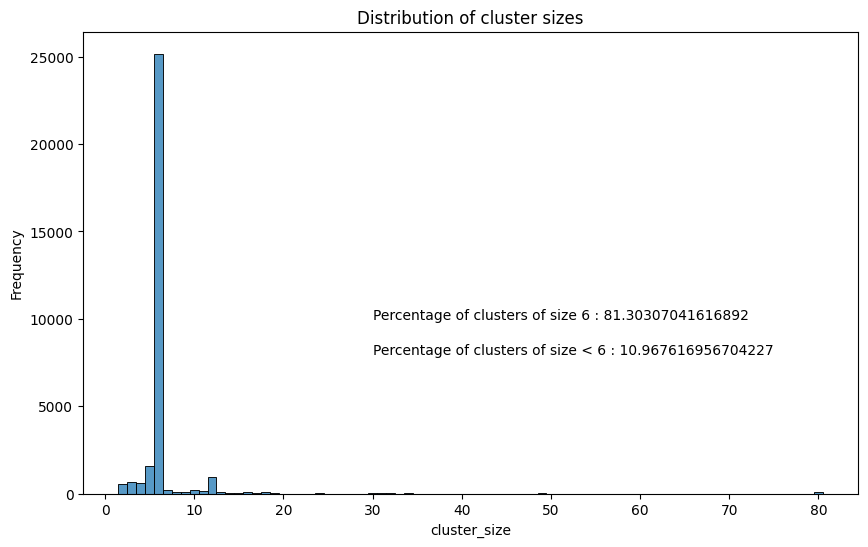

Percentage of clusters of size 6 : 81.30307041616892
Percentage of clusters of size < 6 : 10.967616956704227


In [15]:

data = df.select("cluster_size").to_pandas()
pdf["cluster_size"] = data["cluster_size"].astype('int')    
data["cluster_size"] = data["cluster_size"].astype('category')
plt.figure(figsize=(10,6))
sns.histplot(x=data['cluster_size'], bins = 50)
plt.title('Distribution of cluster sizes')
plt.ylabel('Frequency')

plt.annotate(f'Percentage of clusters of size 6 : {pdf[pdf["cluster_size"] == 6].shape[0] / pdf.shape[0] * 100}', xy=(30, 10000))
plt.annotate(f'Percentage of clusters of size < 6 : {pdf[pdf["cluster_size"] < 6].shape[0] / pdf.shape[0] * 100}', xy=(30, 8000))
plt.show()                                                                                                                                  

# Number of clusters of size 6 :
                                                                                                             

print(f'Percentage of clusters of size 6 : {pdf[pdf["cluster_size"] == 6].shape[0] / pdf.shape[0] * 100}')
print(f'Percentage of clusters of size < 6 : {pdf[pdf["cluster_size"] < 6].shape[0] / pdf.shape[0] * 100}')


In [18]:
pdf.dtypes                                                                                      

cluster_size    int64
dtype: object